In [6]:
pip install pandas numpy matplotlib seaborn xgboost shap scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip install xgboost


In [8]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


Лучшие гиперпараметры: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
RMSE после настройки: 0.56
R² после настройки: 0.68


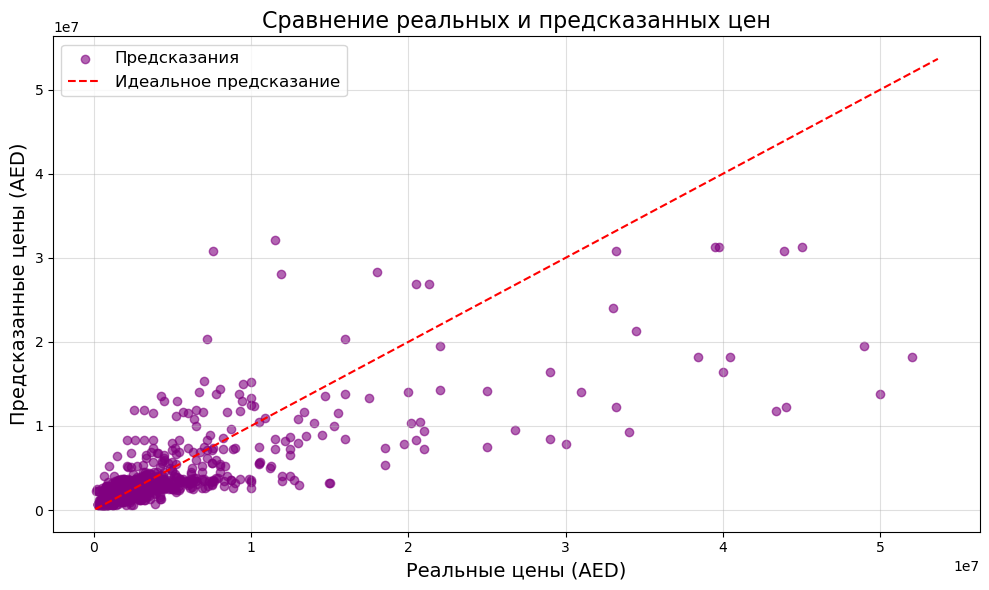

<Figure size 800x600 with 0 Axes>

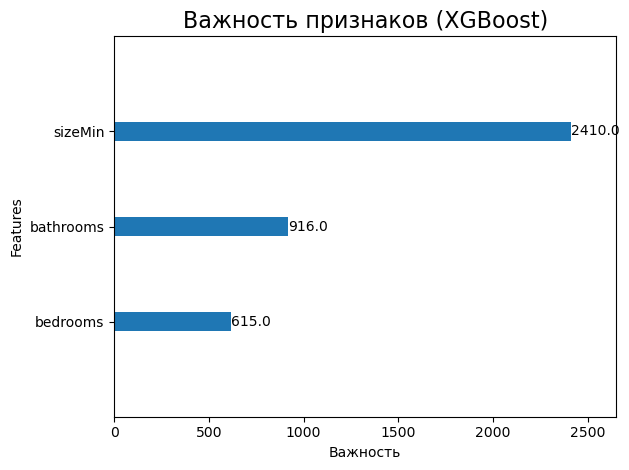

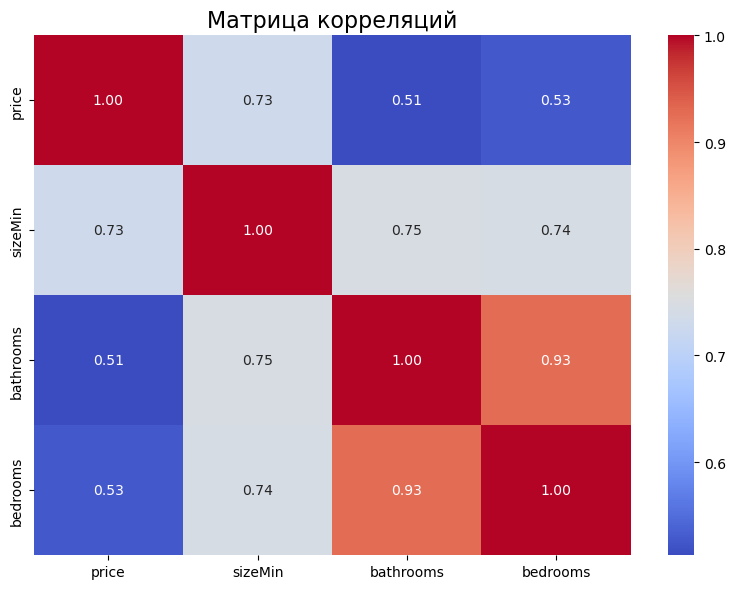

Значимость отдельных признаков (RMSE):
sizeMin: RMSE = 0.58
bathrooms: RMSE = 0.72
bedrooms: RMSE = 0.68


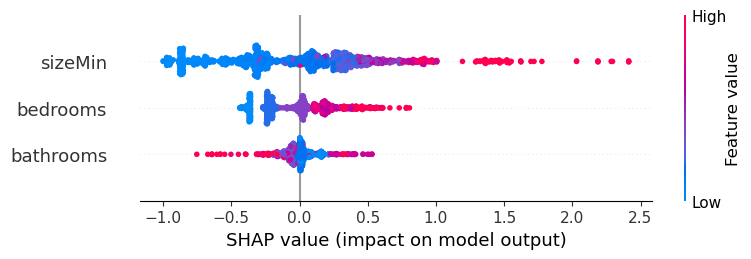

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import shap
import plotly.express as px
import plotly.offline as pyo

# Инициализация Plotly для Jupyter Notebook
pyo.init_notebook_mode(connected=True)

# Загрузка данных
df = pd.read_csv('uae_real_estate_2024.csv')

# Очистка данных
# Конвертация площади из sqft в м²
df['sizeMin'] = (
    df['sizeMin']
    .str.replace(' sqft', '', regex=False)
    .str.replace(',', '', regex=False)
    .replace('none', np.nan)  # Замена 'none' на NaN
    .astype(float)
)
df['sizeMin'] = df['sizeMin'] * 0.092903  # Перевод в квадратные метры

# Конвертация цен из AED в числовой формат
df['price'] = df['price'].replace('none', np.nan).astype(float)

# Замена 'none' в других столбцах
df['bathrooms'] = df['bathrooms'].replace('none', np.nan).replace('7+', '7').astype(float)
df['bedrooms'] = df['bedrooms'].replace('none', np.nan).replace('7+', '7').replace('studio', 0).astype(float)

# Заполнение пропусков медианой
df['sizeMin'] = df['sizeMin'].fillna(df['sizeMin'].median())
df['price'] = df['price'].fillna(df['price'].median())
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())

# Удаление выбросов
df = df[(df['price'] < df['price'].quantile(0.99)) & (df['sizeMin'] < df['sizeMin'].quantile(0.99))]

# Разделение данных
X = df[['sizeMin', 'bathrooms', 'bedrooms']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Логарифмическое преобразование целевой переменной для улучшения модели
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# Поиск лучших гиперпараметров с использованием GridSearchCV
param_grid = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBRegressor
xg_model = xgb.XGBRegressor(random_state=42)

# Поиск по сетке
grid_search = GridSearchCV(xg_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие гиперпараметры:", grid_search.best_params_)

# Оценка модели с лучшими параметрами
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE после настройки: {rmse:.2f}")
print(f"R² после настройки: {r2:.2f}")

# График сравнения реальных и предсказанных цен (в дирхамах)
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.6, color='purple', label='Предсказания')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Идеальное предсказание')
plt.title("Сравнение реальных и предсказанных цен", fontsize=16)
plt.xlabel("Реальные цены (AED)", fontsize=14)
plt.ylabel("Предсказанные цены (AED)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Важность признаков
plt.figure(figsize=(8, 6))
xgb.plot_importance(best_model, importance_type='weight', xlabel="Важность", grid=False)
plt.title("Важность признаков (XGBoost)", fontsize=16)
plt.tight_layout()
plt.show()

# Корреляция между признаками
correlation_matrix = df[['price', 'sizeMin', 'bathrooms', 'bedrooms']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляций", fontsize=16)
plt.tight_layout()
plt.show()

# Проверка значимости отдельных признаков
feature_rmse = {}
for feature in X.columns:
    X_single = X_train[[feature]]
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_single, y_train)
    y_single_pred = model.predict(X_test[[feature]])
    rmse_single = np.sqrt(mean_squared_error(y_test, y_single_pred))
    feature_rmse[feature] = rmse_single
print("Значимость отдельных признаков (RMSE):")
for feature, rmse_val in feature_rmse.items():
    print(f"{feature}: RMSE = {rmse_val:.2f}")

# SHAP для интерпретации
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# Визуализация SHAP
shap.summary_plot(shap_values, X_test)

# Анализ по городам и районам
df = df[~df[['title', 'displayAddress', 'sizeMin']].duplicated()]

# Разделение адреса на компоненты
df['city'] = df.displayAddress.str.split(',').apply(lambda x: x[-1].strip())
df['area_1'] = df.displayAddress.str.split(',').apply(lambda x: x[-2].strip())

# Подсчет количества объявлений по городам и районам
data_df = df[['city', 'area_1']].groupby(by=['city', 'area_1']).size().reset_index(name='count')

# Выборка топ 10 городов по количеству объявлений
top_10_cities = data_df.groupby('city')['count'].sum().nlargest(10).index
data_df_top_10 = data_df[data_df['city'].isin(top_10_cities)]

# Визуализация с использованием Plotly Treemap
fig = px.treemap(
    data_df_top_10, 
    path=[px.Constant("All Cities"), 'city', 'area_1'], 
    values='count',
    color='count',
    color_continuous_scale='Viridis',
    title="Количество объектов недвижимости по городам"
)

# Обновление шрифта для title
fig.update_layout(
    title_font=dict(
        family="Arial",  # Шрифт
        size=24,         # Размер шрифта
        color="black"    # Цвет шрифта
    )
)
fig.show()
